In [1]:
#Импортируем необходимые для лабораторной библиотеки

import copy
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from dateutil.relativedelta import relativedelta

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
#Загрузим датасет и убедимся в корректности данных

df = pd.read_csv('./Netflix_Historical_StockPrice2.csv')
df.head(13)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-04-01,102.930000,105.790001,102.470001,105.699997,105.699997,14182400
1,2016-04-04,105.900002,105.919998,103.199997,104.349998,104.349998,10940400
2,2016-04-05,103.470001,105.750000,103.250000,104.940002,104.940002,10060900
3,2016-04-06,105.300003,106.440002,104.250000,104.830002,104.830002,9605800
4,2016-04-07,104.309998,106.440002,103.599998,104.449997,104.449997,10774900
5,2016-04-08,105.120003,105.330002,102.820000,103.809998,103.809998,7857600
6,2016-04-11,104.040001,104.980003,102.620003,102.680000,102.680000,7451300
7,2016-04-12,103.150002,107.220001,102.209999,106.980003,106.980003,12437000
8,2016-04-13,108.000000,111.279999,107.879997,109.650002,109.650002,16701700
9,2016-04-14,110.010002,111.639999,109.150002,110.419998,110.419998,9553700


In [3]:
#Определим размерность датасета

df.shape

(1256, 7)

In [4]:
# Проанализируем базовые статистики имеющихся признаков

df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03
mean,293.027436,297.549594,288.277731,293.077500,293.077500,8.436514e+06
std,135.142288,137.462294,132.600776,135.063317,135.063317,5.514222e+06
min,85.430000,86.500000,84.500000,85.330002,85.330002,1.144000e+06
25%,160.875000,162.732502,159.652496,161.042496,161.042496,5.017050e+06
50%,308.769989,314.255005,303.504990,309.315002,309.315002,6.927250e+06
75%,371.122498,376.487495,364.712502,370.779999,370.779999,1.004768e+07
max,582.450012,593.289978,570.400024,586.340027,586.340027,5.841040e+07


In [5]:
#Преобразуем столбец 'Date' к формату datetime

df['Date'] = pd.to_datetime(df['Date'])

#Считаем цену по месяцам

res = df.set_index('Date').groupby(pd.Grouper(freq='M'))['High'].mean().reset_index()

#Сделаем  'datetime'  индексом для датасета

df = df.set_index(['Date'])
df.sort_index(inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-04-01,102.930000,105.790001,102.470001,105.699997,105.699997,14182400
2016-04-04,105.900002,105.919998,103.199997,104.349998,104.349998,10940400
2016-04-05,103.470001,105.750000,103.250000,104.940002,104.940002,10060900
2016-04-06,105.300003,106.440002,104.250000,104.830002,104.830002,9605800
2016-04-07,104.309998,106.440002,103.599998,104.449997,104.449997,10774900


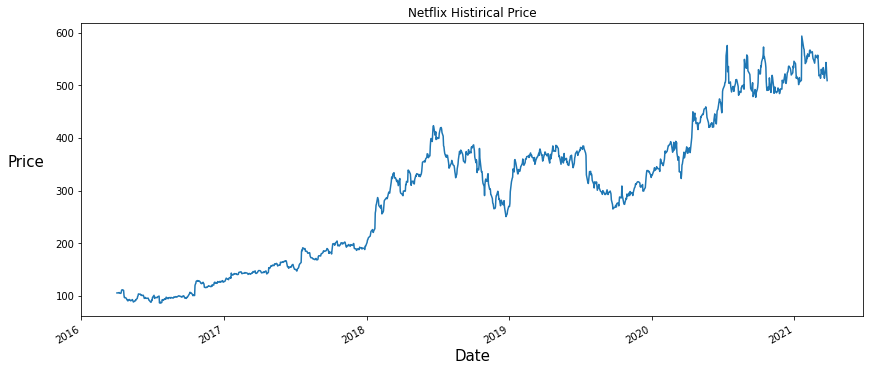

In [6]:
# Рассмотрим изменение цены

plt.figure(figsize=(14, 6))
plt.title('Netflix Histirical Price')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', rotation=0, labelpad=30, fontsize=15)
df['High'].plot();

In [7]:
#Выводим данные по месяцам

res = res.set_index(['Date'])
print(res)

                  High
Date                  
2016-04-30  102.418572
2016-05-31   94.337619
2016-06-30   95.731817
2016-07-31   94.064499
2016-08-31   96.454347
2016-09-30   98.434285
2016-10-31  114.473809
2016-11-30  120.292858
2016-12-31  125.443810
2017-01-31  136.404501
2017-02-28  143.451579
2017-03-31  144.332608
2017-04-30  146.791579
2017-05-31  159.688636
2017-06-30  158.527272
2017-07-31  171.361000
2017-08-31  174.345653
2017-09-30  183.437499
2017-10-31  196.430455
2017-11-30  197.064762
2017-12-31  190.018500
2018-01-31  235.313333
2018-02-28  276.718422
2018-03-31  317.424284
2018-04-30  313.808098
2018-05-31  333.969094
2018-06-30  389.790475
2018-07-31  387.179047
2018-08-31  351.161738
2018-09-30  369.201578
2018-10-31  346.519998
2018-11-30  297.460474
2018-12-31  273.846315
2019-01-31  330.171427
2019-02-28  360.118423
2019-03-31  364.034287
2019-04-30  370.220952
2019-05-31  364.242730
2019-06-30  361.372998
2019-07-31  354.747271
2019-08-31  307.162728
2019-09-30 

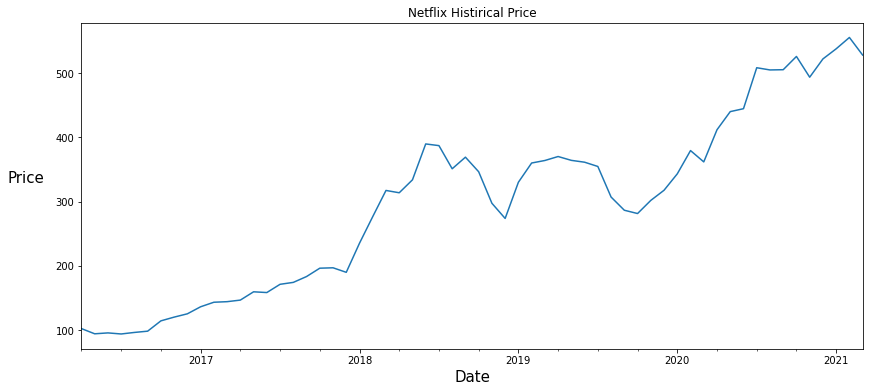

In [8]:
# Рассмотрим изменение цены по месяцам

plt.figure(figsize=(14, 6))
plt.title('Netflix Histirical Price')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', rotation=0, labelpad=30, fontsize=15)
res['High'].plot();

<AxesSubplot:title={'center':'Netflix Histirical Price \n Trend'}, xlabel='Date', ylabel='Price'>

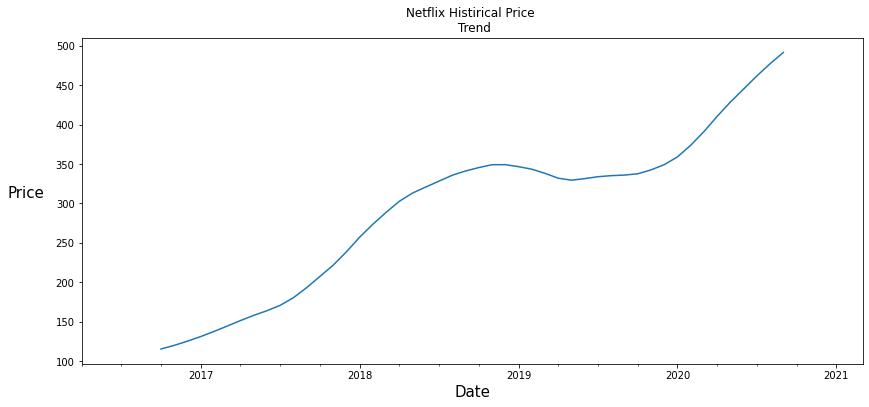

In [9]:
#Разобьем данные на периоды, чтобы оценить тренд

decompose = seasonal_decompose(res[['High']], period=12)


#Построим график
plt.figure(figsize=(14, 6))
plt.title('Netflix Histirical Price \n Trend')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', rotation=0, labelpad=30, fontsize=15)
decompose.trend.plot()

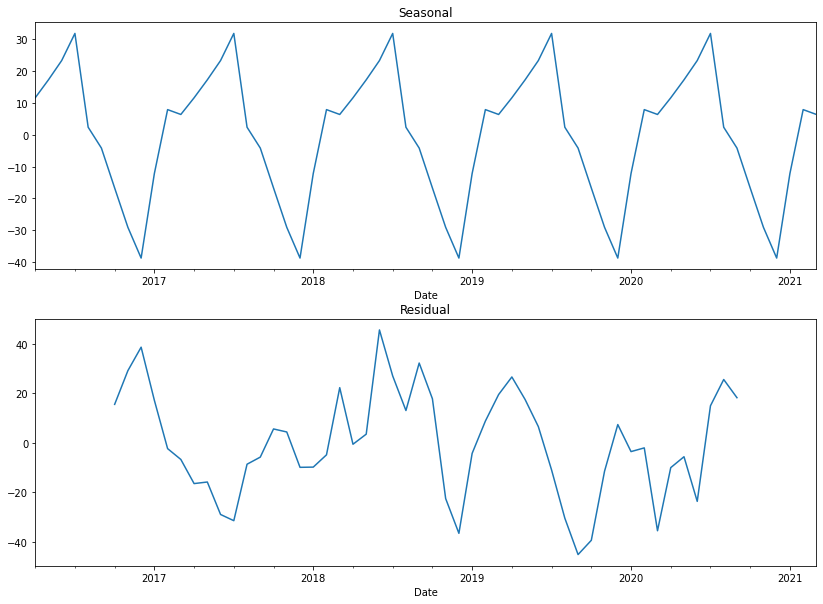

In [10]:
#Построим временные ряды

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

#График отражающий сезонность и отклонение ошибки
ax[0].set_title('Seasonal')
ax[1].set_title('Residual')

decompose.seasonal.plot(ax=ax[0])
decompose.resid.plot(ax=ax[1]);

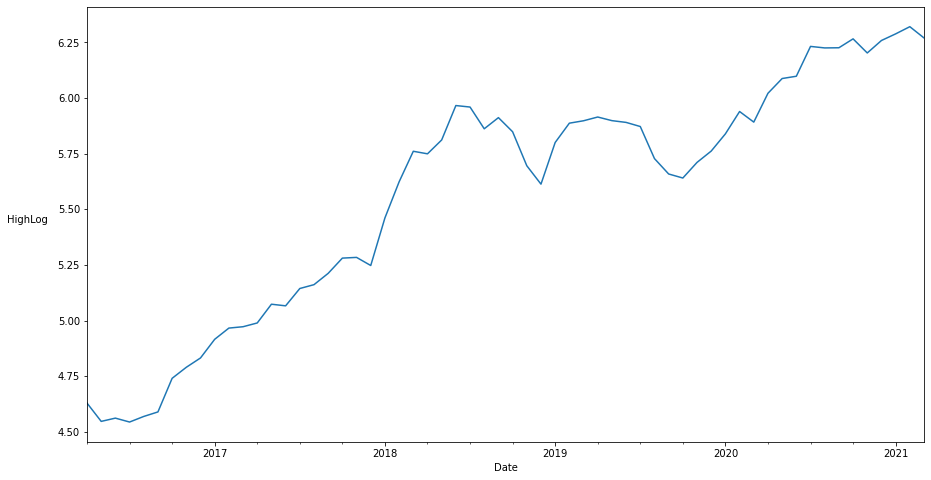

In [11]:
res['HighLog'] = np.log(res['High'])

plt.figure(figsize=(15, 8))
plt.ylabel('HighLog', rotation=0, labelpad=30)
res['HighLog'].plot();

Полученный уровень значимости (p-value): 0.3848. 0.3848 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


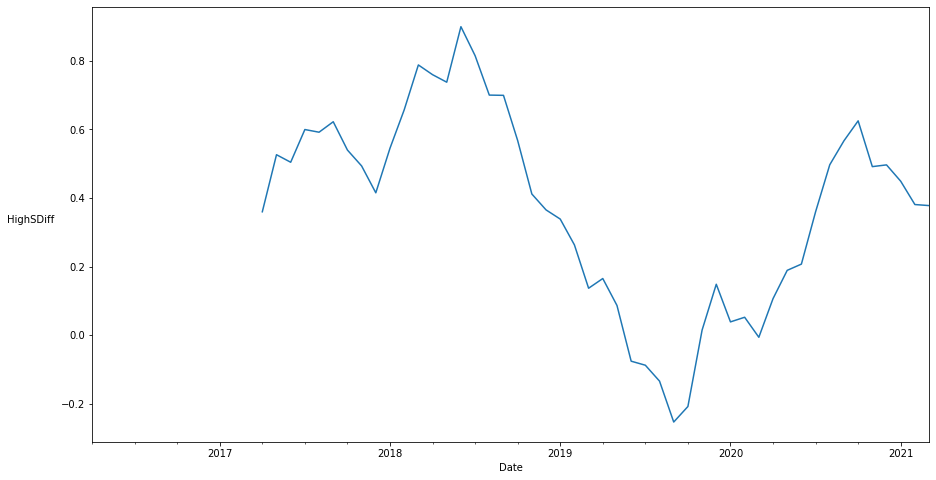

In [12]:
res['HighLogSDiff'] = res['HighLog'] - res['HighLog'].shift(12)
p_value = adfuller(res["HighLogSDiff"][13:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)

plt.figure(figsize=(15, 8))
plt.ylabel('HighSDiff', rotation=0, labelpad=30)
res['HighLogSDiff'].plot();

Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


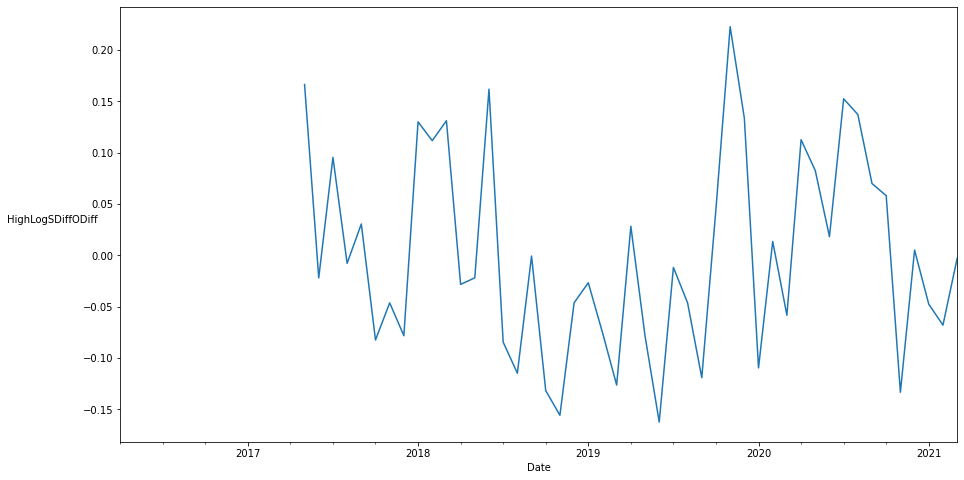

In [13]:
res['HighLogSDiffODiff'] = res['HighLogSDiff'] - res['HighLogSDiff'].shift(1)
p_value = adfuller(res["HighLogSDiffODiff"][13:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)

plt.figure(figsize=(15, 8))
plt.ylabel('HighLogSDiffODiff', rotation=0, labelpad=30)
res['HighLogSDiffODiff'].plot();

D:\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


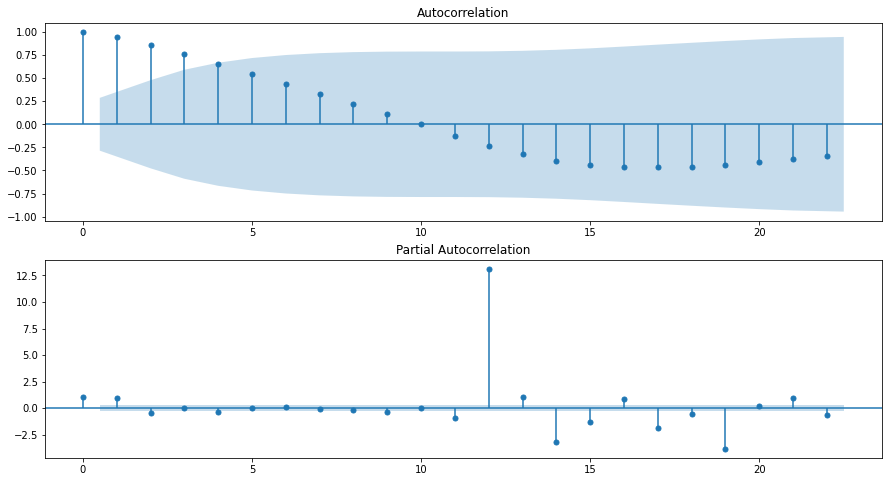

In [14]:
plt.figure(figsize=(15,8))

ax = plt.subplot(211)
statsmodels.graphics.tsaplots.plot_acf(res['HighLogSDiff'][13:], lags=22, ax=ax)

ax = plt.subplot(212)
statsmodels.graphics.tsaplots.plot_pacf(res['HighLogSDiff'][13:], lags=22, ax=ax);

In [15]:
d=1
D=1

qs = range(1, 5)
Qs = range(1, 3)

ps = range(1, 5)
Ps = range(3, 5)

In [16]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [17]:
#warnings.filterwarnings('ignore')
import statsmodels.api as sm


results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            res['HighLog'], 
            order=(param[0], d, param[1]), 
            seasonal_order=(param[2], D, param[3], 12)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

#warnings.filterwarnings('default')

  0%|          | 0/64 [00:00<?, ?it/s]D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1008: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
  2%|▏         | 1/64 [00:03<03:29,  3.32s/it]D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524

In [18]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
0   (1, 1, 3, 1) -88.742662
2   (1, 1, 4, 1) -87.140695
4   (1, 2, 3, 1) -87.017076
16  (2, 1, 3, 1) -87.010450
1   (1, 1, 3, 2) -86.978945


In [19]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            HighLog   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(3, 1, 1, 12)   Log Likelihood                  51.371
Date:                            Wed, 10 Nov 2021   AIC                            -88.743
Time:                                    11:29:21   BIC                            -75.792
Sample:                                04-30-2016   HQIC                           -83.869
                                     - 03-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6369      0.461      1.382      0.167      -0.267       1.540
ma.L1         -0.4116      0.548   

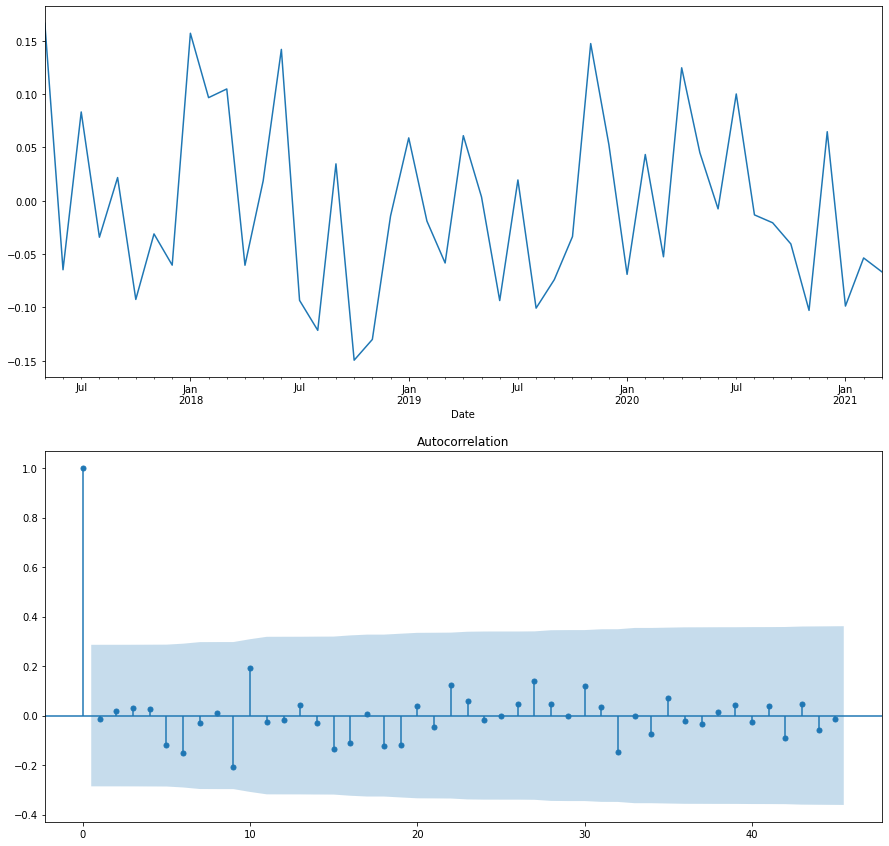

In [20]:
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid[13:].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=45, ax=ax);

<AxesSubplot:xlabel='Date'>

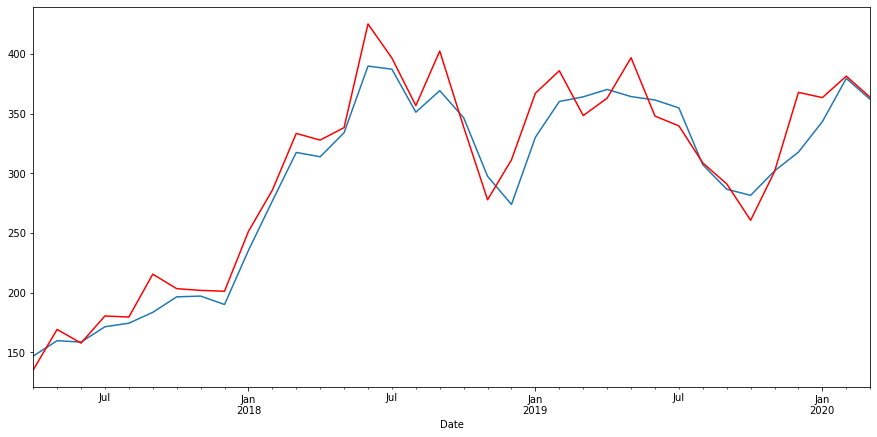

In [21]:
res['Model'] = np.exp(best_model.fittedvalues)


res1 = res ['Model']
res1 = res1.shift(-1)
res['Model'] = res1
plt.figure(figsize=(15,7))

res['High'][12:48].plot()
res['Model'][12:48].plot(c='r')


In [22]:
print(res.shape)
res.tail()

(60, 5)


,High,HighLog,HighLogSDiff,HighLogSDiffODiff,Model
Date,,,,,
2020-11-30,493.651497,6.201830,0.491621,-0.133474,489.377017
2020-12-31,522.098178,6.257856,0.496691,0.005070,593.650593
2021-01-31,537.838944,6.287559,0.449083,-0.047608,586.094801
2021-02-28,555.494205,6.319858,0.381051,-0.068033,564.455381
2021-03-31,528.089000,6.269265,0.378021,-0.003029,NaN


In [23]:
predict_len = 12
#res = res.set_index(['Date'])
new_close_value = res[['High', 'Model']]
future_date = [
    datetime.datetime.strptime("2019-12-31", "%Y-%m-%d") + relativedelta(months=x)
    for x in range(0, predict_len)
]




future_df = pd.DataFrame(index=future_date, columns=['High', 'Model'])

new_close_value = pd.concat([new_close_value, future_df])

print(new_close_value.shape)
new_close_value.tail()

(72, 2)


,High,Model
2020-07-31,NaN,NaN
2020-08-31,NaN,NaN
2020-09-30,NaN,NaN
2020-10-31,NaN,NaN
2020-11-30,NaN,NaN


<AxesSubplot:>

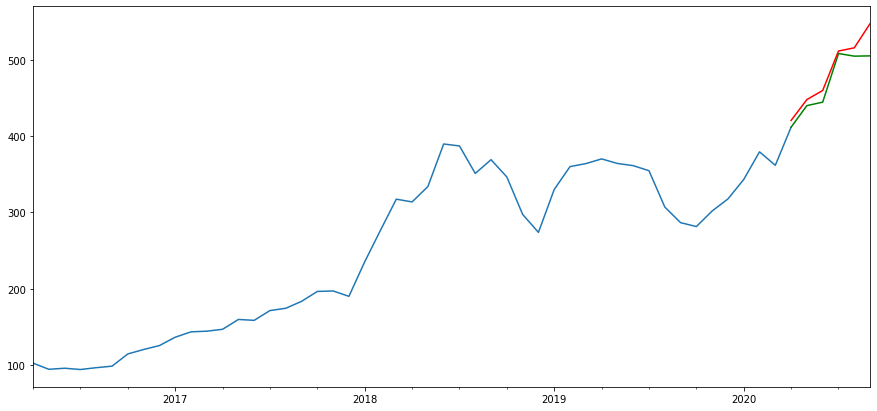

In [24]:
plt.figure(figsize=(15,7))
new_close_value['High'][:49].plot()
new_close_value['High'][48:54].plot(c='g')
new_close_value['Model'][48:54].plot(c='r')

In [25]:
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
MAPE(res['High'], new_close_value['Model'])

19.502820169677726